# Building a Recurrent Neural Network with PyTorch
__Originally Created:__ 09/05/2020 8:14PM

__V1.1 Created:__ 14/05/2020 7:43PM

__Last Edited:__ 14/05/2020 7:43PM

__Firstly, I would like to thank Deep Learning Wizard for this resource.__
https://www.deeplearningwizard.com/deep_learning/practical_pytorch/pytorch_recurrent_neuralnetwork/

In [30]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.utils.data import DataLoader
from torch.autograd import Variable

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

In [135]:
import numpy as np
import pandas as pd

In [121]:
import itertools

In [17]:
import time

# First, I'm going to explore the methods that didn't result in a good model/ Why didn't the model get better?
## Dataset used: FashionMNIST

In [3]:
train_data = dset.FashionMNIST(root='./data',
                               train = True,
                               transform=transforms.ToTensor(),
                               download = True)

test_data = dset.FashionMNIST(root='./data',
                               train = False,
                               transform=transforms.ToTensor())

#### Make Datasets Iterable

In [4]:
train_loader = DataLoader(dataset = train_data, batch_size = 100, shuffle = True)
test_loader = DataLoader(dataset = test_data, batch_size = 100, shuffle = True)

In [6]:
batch_size = 100
n_iters = 3000
num_epochs = n_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)

#### Create the Model

In [7]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()
        
        # Hidden Dimensions
        self.hidden_dim = hidden_dim
        
        # Number of Hidden Layers
        self.layer_dim = layer_dim
        
        # Building your RNN
        # batch_first = True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, input_dim)
        # batch_dim = number of samples per batch
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='relu')
        
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # Initialize hidden state with zeros
        # (layer_dim, batch_size, hidden_dim)
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        
        # We need to detach the hidden state to prevent exploding/vanishing gradients
        # This is part of the truncated backpropagation through time (BPTT)
        out, hn = self.rnn(x, h0.detach())
        
        # Index hidden state of last time step
        # out.size() --> 100, 28, 10
        # out[:, -1, :] --> 100, 10 --> just want last time step hidden states!
        out = self.fc(out[:, -1, :])
        # out.size() --> 100, 10
        return out

#### Instantiate Model Class
- 28 time steps
   - Each time step: input dimension = 28
- 1 hidden layer
- MNIST 1-9 digits --> output dimension = 10

In [14]:
input_dim = 28
hidden_dim = 100
layer_dim = 1
output_dim = 10

#### Other Information

In [21]:
model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim)

criterion = nn.CrossEntropyLoss()

learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

len(list(model.parameters()))

6

#### Train Model

In [18]:
num_epochs

5

In [22]:
# Starting time
start_time = time.time()

# Number of swteps to unroll
seq_dim = 28

iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        #model.train()
        
        # Load images as tensors with gradient accumulation abilities
        images = images.view(-1, seq_dim, input_dim).requires_grad_()
        
        # Clear gradients wrt parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        # outputs.size() --> 100, 10
        outputs = model(images)
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        # Getting gradients wrt parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        
        iter += 1
        
        if iter % 500 == 0:
            model.eval()
            
            # Calculate Accuracy
            correct = 0
            total = 0
            
            # Iterate through test dataset
            for images, labels in test_loader:
                
                # Load images to a Torch tensors with gradient accumulation abilities
                images = images.view(-1, seq_dim, input_dim)
                
                # Forward pass only to get logits/output
                outputs = model(images)
                
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                
                # Total number of labels
                total += labels.size(0)
                
                # Total correct predictions
                correct += float((predicted == labels).sum())
                
            accuracy = 100 * correct / total
            
            # Print Loss
            print('Epoch: {}. Iteration: {}. Loss: {:.2f}. Accuracy: {:.2f}'.format(epoch+1, iter, loss.item(), accuracy))
print('Total time: {:.2f}'.format(time.time()-start_time))

Epoch: 1. Iteration: 500. Loss: 2.31. Accuracy: 13.66
Epoch: 2. Iteration: 1000. Loss: 2.34. Accuracy: 13.66
Epoch: 3. Iteration: 1500. Loss: 2.31. Accuracy: 13.66
Epoch: 4. Iteration: 2000. Loss: 2.31. Accuracy: 13.66
Epoch: 5. Iteration: 2500. Loss: 2.31. Accuracy: 13.66
Epoch: 5. Iteration: 3000. Loss: 2.30. Accuracy: 13.66
Total time: 137.85


# LSTM

In [46]:
'''
class LSTMNet(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim)
        self.linear = nn.Linear(hidden_dim, output_dim, bias=False)
        
    def forward(self,x):
        batch_size = x.size()[0]
        h0 = Variable(torch.zeros([1, batch_size, self.hidden_dim]), requires_grad=False)
        c0 = Variable(torch.zeros([1, batch_size, self.hidden_dim]), requires_grad=False)
        fx, _ = self.lstm.forward(x, (h0, c0))
        return self.linear.forward(fx[-1])
'''

In [ ]:
'''
train_size = 60000
n_classes = 10
seq_length = 28
input_dim = 28
hidden_dim = 128
batch_size = 100
epochs = 10

# Device Configuration
device = torch.device('cpu')

# Convert the data to the shape (seq_length, num_samples, input_dim)
model = LSTMNet(input_dim, hidden_dim, n_classes)
loss = torch.nn.CrossEntropyLoss(reduction='elementwise_mean')
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
'''

In [50]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.layer_dim = layer_dim

        # Building your LSTM
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # 28 time steps
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 28, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out


In [82]:
input_dim = 28
hidden_dim = 100
layer_dim = 1
output_dim = 10

#device = torch.device('cpu')
model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)
criterion = nn.CrossEntropyLoss()
loss = torch.nn.CrossEntropyLoss(reduction='elementwise_mean')
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [83]:
# Starting time
start_time = time.time()

# Number of swteps to unroll
seq_dim = 28

iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        #model.train()
        
        # Load images as tensors with gradient accumulation abilities
        images = images.view(-1, seq_dim, input_dim).requires_grad_()
        
        #images = images.to(device)
        #labels = labels.to(device)
        
        # Clear gradients wrt parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        # outputs.size() --> 100, 10
        outputs = model(images)
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        # Getting gradients wrt parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        
        iter += 1
        
        if iter % 500 == 0:
            model.eval()
            
            # Calculate Accuracy
            correct = 0
            total = 0
            
            # Iterate through test dataset
            for images, labels in test_loader:
                
                # Load images to a Torch tensors with gradient accumulation abilities
                images = images.view(-1, seq_dim, input_dim)
                
                # Forward pass only to get logits/output
                outputs = model(images).argmax(axis=1)
                
                # Total number of labels
                total += labels.size(0)
                
                # Total correct predictions
                correct += float((outputs == labels).sum())
                
            accuracy = 100 * correct / total
            
            # Print Loss
            print('Epoch: {}. Iteration: {}. Loss: {:.2f}. Accuracy: {:.2f}'.format(epoch+1, iter, loss.item(), accuracy))
print('Total time: {:.2f}'.format(time.time()-start_time))

Epoch: 1. Iteration: 500. Loss: 0.94. Accuracy: 59.96
Epoch: 2. Iteration: 1000. Loss: 0.70. Accuracy: 73.62
Epoch: 3. Iteration: 1500. Loss: 0.66. Accuracy: 78.25
Epoch: 4. Iteration: 2000. Loss: 0.45. Accuracy: 80.40
Epoch: 5. Iteration: 2500. Loss: 0.42. Accuracy: 82.97
Epoch: 5. Iteration: 3000. Loss: 0.45. Accuracy: 83.81
Total time: 305.34


### 10 epochs

In [128]:
input_dim = 28
hidden_dim = 100
layer_dim = 1
output_dim = 10

#device = torch.device('cpu')
model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)
criterion = nn.CrossEntropyLoss()
loss = torch.nn.CrossEntropyLoss(reduction='elementwise_mean')
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

num_epochs = 20

# Starting time
start_time = time.time()

# Number of swteps to unroll
seq_dim = 28

iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        #model.train()
        
        # Load images as tensors with gradient accumulation abilities
        images = images.view(-1, seq_dim, input_dim).requires_grad_()
        
        #images = images.to(device)
        #labels = labels.to(device)
        
        # Clear gradients wrt parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        # outputs.size() --> 100, 10
        outputs = model(images)
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        # Getting gradients wrt parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        
        iter += 1
        
        if iter % 500 == 0:
            model.eval()
            
            # Calculate Accuracy
            correct = 0
            total = 0
            
            # Iterate through test dataset
            for images, labels in test_loader:
                
                # Load images to a Torch tensors with gradient accumulation abilities
                images = images.view(-1, seq_dim, input_dim)
                
                # Forward pass only to get logits/output
                outputs = model(images).argmax(axis=1)
                
                # Total number of labels
                total += labels.size(0)
                
                # Total correct predictions
                correct += float((outputs == labels).sum())
                
            accuracy = 100 * correct / total
            
            # Print Loss
            print('Epoch: {}. Iteration: {}. Loss: {:.2f}. Accuracy: {:.2f}'.format(epoch+1, iter, loss.item(), accuracy))
print('Total time: {:.2f}'.format(time.time()-start_time))


Epoch: 1. Iteration: 500. Loss: 0.88. Accuracy: 60.81
Epoch: 2. Iteration: 1000. Loss: 0.54. Accuracy: 73.13
Epoch: 3. Iteration: 1500. Loss: 0.57. Accuracy: 78.16
Epoch: 4. Iteration: 2000. Loss: 0.64. Accuracy: 81.93
Epoch: 5. Iteration: 2500. Loss: 0.59. Accuracy: 82.84
Epoch: 5. Iteration: 3000. Loss: 0.58. Accuracy: 83.22
Epoch: 6. Iteration: 3500. Loss: 0.52. Accuracy: 83.99
Epoch: 7. Iteration: 4000. Loss: 0.51. Accuracy: 84.21
Epoch: 8. Iteration: 4500. Loss: 0.41. Accuracy: 84.94
Epoch: 9. Iteration: 5000. Loss: 0.43. Accuracy: 84.67
Epoch: 10. Iteration: 5500. Loss: 0.27. Accuracy: 86.07
Epoch: 10. Iteration: 6000. Loss: 0.34. Accuracy: 85.83
Epoch: 11. Iteration: 6500. Loss: 0.31. Accuracy: 85.59
Epoch: 12. Iteration: 7000. Loss: 0.43. Accuracy: 86.40
Epoch: 13. Iteration: 7500. Loss: 0.25. Accuracy: 85.55
Epoch: 14. Iteration: 8000. Loss: 0.35. Accuracy: 86.99
Epoch: 15. Iteration: 8500. Loss: 0.37. Accuracy: 87.23
Epoch: 15. Iteration: 9000. Loss: 0.32. Accuracy: 86.65
Epo

In [86]:
model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim)

criterion = nn.CrossEntropyLoss()

learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [87]:
# Starting time
start_time = time.time()

# Number of swteps to unroll
seq_dim = 28

iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        #model.train()
        
        # Load images as tensors with gradient accumulation abilities
        images = images.view(-1, seq_dim, input_dim).requires_grad_()
        
        # Clear gradients wrt parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        # outputs.size() --> 100, 10
        outputs = model(images)
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        # Getting gradients wrt parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        
        iter += 1
        
        if iter % 500 == 0:
            model.eval()
            
            # Calculate Accuracy
            correct = 0
            total = 0
            
            # Iterate through test dataset
            for images, labels in test_loader:
                
                # Load images to a Torch tensors with gradient accumulation abilities
                images = images.view(-1, seq_dim, input_dim)
                
                # Forward pass only to get logits/output
                outputs = model(images)
                
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                
                # Total number of labels
                total += labels.size(0)
                
                # Total correct predictions
                correct += float((predicted == labels).sum())
                
            accuracy = 100 * correct / total
            
            # Print Loss
            print('Epoch: {}. Iteration: {}. Loss: {:.2f}. Accuracy: {:.2f}'.format(epoch+1, iter, loss.item(), accuracy))
print('Total time: {:.2f}'.format(time.time()-start_time))

Epoch: 1. Iteration: 500. Loss: 2.09. Accuracy: 23.04
Epoch: 2. Iteration: 1000. Loss: 1.37. Accuracy: 46.58
Epoch: 3. Iteration: 1500. Loss: 1.21. Accuracy: 54.00
Epoch: 4. Iteration: 2000. Loss: 0.94. Accuracy: 63.64
Epoch: 5. Iteration: 2500. Loss: 0.64. Accuracy: 72.71
Epoch: 5. Iteration: 3000. Loss: 0.66. Accuracy: 68.90
Epoch: 6. Iteration: 3500. Loss: 0.63. Accuracy: 71.72
Epoch: 7. Iteration: 4000. Loss: 0.69. Accuracy: 76.31
Epoch: 8. Iteration: 4500. Loss: 0.71. Accuracy: 78.93
Epoch: 9. Iteration: 5000. Loss: 0.63. Accuracy: 78.65
Epoch: 10. Iteration: 5500. Loss: 0.51. Accuracy: 80.25
Epoch: 10. Iteration: 6000. Loss: 0.50. Accuracy: 80.32
Epoch: 11. Iteration: 6500. Loss: 0.48. Accuracy: 80.48
Epoch: 12. Iteration: 7000. Loss: 0.44. Accuracy: 80.59
Epoch: 13. Iteration: 7500. Loss: 0.57. Accuracy: 81.27
Epoch: 14. Iteration: 8000. Loss: 0.32. Accuracy: 82.17
Epoch: 15. Iteration: 8500. Loss: 0.58. Accuracy: 82.29
Epoch: 15. Iteration: 9000. Loss: 0.63. Accuracy: 82.11
Epo

## The other thing I want to do is to check the number of each class

In [110]:
train_labels = np.zeros([10])
test_labels = np.zeros([10])

In [111]:
for (_,labels) in train_loader:
    for i in range(10):
        train_labels[i] += (labels == i).sum().item()

for (_,labels) in test_loader:
    for i in range(10):
        test_labels[i] += (labels == i).sum().item()

In [108]:
labels

tensor([5, 9, 2, 7, 9, 7, 5, 5, 4, 8, 1, 8, 0, 6, 2, 6, 6, 6, 0, 9, 1, 9, 8, 0,
        2, 2, 6, 3, 6, 3, 0, 3, 3, 9, 6, 0, 3, 0, 3, 6, 0, 9, 3, 6, 5, 7, 6, 9,
        8, 3, 2, 8, 3, 4, 4, 1, 1, 9, 0, 8, 6, 7, 5, 1, 5, 6, 8, 8, 9, 4, 5, 9,
        7, 1, 8, 2, 1, 5, 0, 3, 8, 5, 7, 9, 7, 1, 5, 9, 2, 0, 5, 6, 0, 8, 8, 8,
        4, 9, 0, 0])

In [99]:
(labels == 7).sum().item()

10

In [107]:
train_labels

array([6000., 6000., 6000., 6000., 6000., 6000., 6000., 6000., 6000.,
       6000.])

In [112]:
test_labels

array([1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
       1000.])

### Plot Confusion Matrices for each model

In [113]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    # Starting time
start_time = time.time()

# Number of swteps to unroll
seq_dim = 28

### RNN model

torch.Size([100, 1, 28, 28])

In [118]:
start = time.time()
cmt = np.zeros((10,10),dtype=int)
for (image, label) in test_loader:
    image = image.view(-1, seq_dim, input_dim)
    
    output = model(image).argmax(axis=1)
    for i in range(100):
        cmt[label[i].item(),output[i].item()] += 1
time.time() - start

1.8717496395111084

In [119]:
cmt

array([[773,   0,  17,  71,   2,   2, 120,   0,  15,   0],
       [  3, 936,   7,  39,   4,   6,   5,   0,   0,   0],
       [ 13,   0, 771,  16, 134,   1,  57,   0,   7,   1],
       [ 33,   5,  19, 880,  35,   1,  21,   0,   5,   1],
       [  0,   1, 107,  33, 815,   0,  34,   0,  10,   0],
       [  0,   0,   0,   0,   0, 978,   0,   9,   5,   8],
       [156,   0, 130,  48, 156,   1, 479,   0,  30,   0],
       [  0,   0,   0,   0,   0, 159,   0, 724,   0, 117],
       [  1,   0,   7,   8,   0,   9,   8,   2, 965,   0],
       [  0,   0,   0,   0,   0,  51,   0,  16,   1, 932]])

In [125]:
plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams.update({'font.size': 12})

Confusion matrix, without normalization
[[773   0  17  71   2   2 120   0  15   0]
 [  3 936   7  39   4   6   5   0   0   0]
 [ 13   0 771  16 134   1  57   0   7   1]
 [ 33   5  19 880  35   1  21   0   5   1]
 [  0   1 107  33 815   0  34   0  10   0]
 [  0   0   0   0   0 978   0   9   5   8]
 [156   0 130  48 156   1 479   0  30   0]
 [  0   0   0   0   0 159   0 724   0 117]
 [  1   0   7   8   0   9   8   2 965   0]
 [  0   0   0   0   0  51   0  16   1 932]]


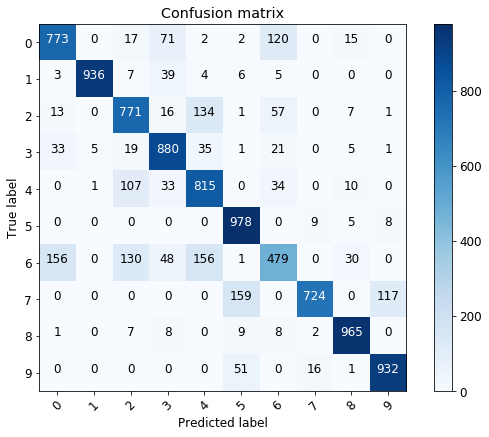

In [127]:
plot_confusion_matrix(cmt, range(10))
plt.savefig('rnn_confusion_matrix.png')

### LSTM

Confusion matrix, without normalization
[[861   2  12  19   3   1  94   0   8   0]
 [  6 969   1  15   3   0   6   0   0   0]
 [ 17   1 803  15 116   0  44   0   4   0]
 [ 44  11  13 878  37   0  14   0   3   0]
 [  0   1  81  24 850   0  41   0   3   0]
 [  1   0   0   0   0 963   0  24   1  11]
 [151   6  78  20 102   0 625   0  18   0]
 [  0   0   0   0   0  20   0 964   0  16]
 [  3   0   7   5   4   1   4   5 971   0]
 [  0   0   0   0   0  10   1  49   0 940]]


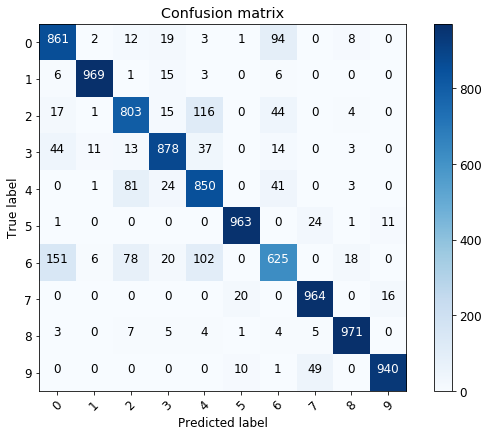

In [129]:
start = time.time()
cmt = np.zeros((10,10),dtype=int)
for (image, label) in test_loader:
    image = image.view(-1, seq_dim, input_dim)
    
    output = model(image).argmax(axis=1)
    for i in range(100):
        cmt[label[i].item(),output[i].item()] += 1
time.time() - start

plot_confusion_matrix(cmt, range(10))
plt.savefig('lstm_confusion_matrix.png')

## Let's try some other RNN/LSTM models (2-layer) and then we do the write-up

In [207]:
## RNN 2-Hidden Layer + ReLU
input_dim = 28
hidden_dim = 100
layer_dim = 2
output_dim = 10

model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim)

criterion = nn.CrossEntropyLoss()
learning_rate = 0.01

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  
seq_dim = 28 
num_epochs = 20

In [208]:
iter = 0
acc_prog = []
loss_prog = []
start_time = time.time()
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        #model.train()
        
        # Load images as tensors with gradient accumulation abilities
        images = images.view(-1, seq_dim, input_dim).requires_grad_()
        
        # Clear gradients wrt parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        # outputs.size() --> 100, 10
        outputs = model(images)
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        # Getting gradients wrt parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        
        iter += 1
        
    model.eval()

    # Calculate Accuracy
    correct = 0
    total = 0

    # Iterate through test dataset
    for images, labels in test_loader:

        # Load images to a Torch tensors with gradient accumulation abilities
        images = images.view(-1, seq_dim, input_dim)

        # Forward pass only to get logits/output
        outputs = model(images)

        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)

        # Total number of labels
        total += labels.size(0)

        # Total correct predictions
        correct += float((predicted == labels).sum())

    accuracy = 100 * correct / total

    # Print Loss
    acc_prog.append(accuracy)
    print('Epoch: {}. Iteration: {}. Loss: {:.2f}. Accuracy: {:.2f}'.format(epoch+1, iter, loss.item(), accuracy))
    loss_prog.append(loss.item())
print('Total time: {:.2f}'.format(time.time()-start_time))

Epoch: 1. Iteration: 600. Loss: 2.06. Accuracy: 26.68
Epoch: 2. Iteration: 1200. Loss: 1.26. Accuracy: 50.63
Epoch: 3. Iteration: 1800. Loss: 0.79. Accuracy: 62.91
Epoch: 4. Iteration: 2400. Loss: 0.81. Accuracy: 70.89
Epoch: 5. Iteration: 3000. Loss: 0.55. Accuracy: 73.54
Epoch: 6. Iteration: 3600. Loss: 0.80. Accuracy: 72.28
Epoch: 7. Iteration: 4200. Loss: 0.65. Accuracy: 72.47
Epoch: 8. Iteration: 4800. Loss: 0.53. Accuracy: 70.49
Epoch: 9. Iteration: 5400. Loss: 0.72. Accuracy: 72.73
Epoch: 10. Iteration: 6000. Loss: 0.52. Accuracy: 80.36
Epoch: 11. Iteration: 6600. Loss: 0.65. Accuracy: 80.84
Epoch: 12. Iteration: 7200. Loss: 0.61. Accuracy: 81.97
Epoch: 13. Iteration: 7800. Loss: 0.33. Accuracy: 82.89
Epoch: 14. Iteration: 8400. Loss: 0.36. Accuracy: 82.78
Epoch: 15. Iteration: 9000. Loss: 0.49. Accuracy: 83.33
Epoch: 16. Iteration: 9600. Loss: 0.38. Accuracy: 82.13
Epoch: 17. Iteration: 10200. Loss: 0.40. Accuracy: 84.28
Epoch: 18. Iteration: 10800. Loss: 0.55. Accuracy: 84.45


In [209]:
rnn2_loss = loss_prog
rnn2_acc = acc_prog

Confusion matrix, without normalization
[[805   5  23  53   4   3  97   0   8   2]
 [  3 953   1  32   7   0   4   0   0   0]
 [ 14   1 791  17 136   1  39   0   1   0]
 [ 36  17  15 856  52   1  22   0   1   0]
 [  1   3 105  22 827   1  37   0   4   0]
 [  1   0   0   0   0 921   0  46   2  30]
 [205   0 144  40 111   0 486   0  14   0]
 [  0   0   0   0   0  15   0 954   0  31]
 [  0   0   9   5   5   3  10   5 962   1]
 [  0   0   1   1   0   9   0  54   0 935]]


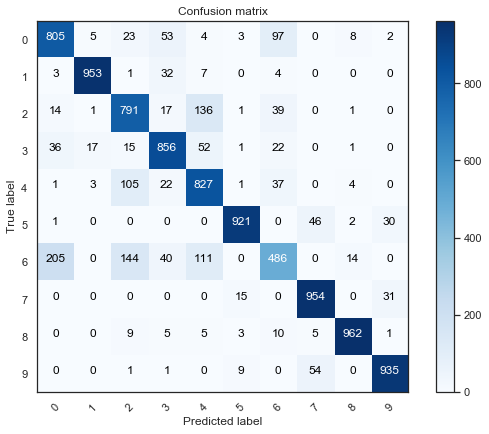

In [211]:
start = time.time()
sns.set_style("white")
cmt = np.zeros((10,10),dtype=int)
for (image, label) in test_loader:
    image = image.view(-1, seq_dim, input_dim)
    
    output = model(image).argmax(axis=1)
    for i in range(100):
        cmt[label[i].item(),output[i].item()] += 1
time.time() - start

plot_confusion_matrix(cmt, range(10))
plt.savefig('rnn2_confusion_matrix.png')

#### LSTM-2

In [254]:
## RNN 2-Hidden Layer + ReLU
input_dim = 28
hidden_dim = 100
layer_dim = 2
output_dim = 10

model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)

criterion = nn.CrossEntropyLoss()
learning_rate = 0.01

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  
seq_dim = 28 
num_epochs = 20

In [255]:
iter = 0
acc_prog = []
loss_prog = []
start_time = time.time()
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        #model.train()
        
        # Load images as tensors with gradient accumulation abilities
        images = images.view(-1, seq_dim, input_dim).requires_grad_()
        
        # Clear gradients wrt parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        # outputs.size() --> 100, 10
        outputs = model(images)
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        # Getting gradients wrt parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        
        iter += 1
        
    model.eval()

    # Calculate Accuracy
    correct = 0
    total = 0

    # Iterate through test dataset
    for images, labels in test_loader:

        # Load images to a Torch tensors with gradient accumulation abilities
        images = images.view(-1, seq_dim, input_dim)

        # Forward pass only to get logits/output
        outputs = model(images)

        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)

        # Total number of labels
        total += labels.size(0)

        # Total correct predictions
        correct += float((predicted == labels).sum())

    accuracy = 100 * correct / total

    # Print Loss
    acc_prog.append(accuracy)
    print('Epoch: {}. Iteration: {}. Loss: {:.2f}. Accuracy: {:.2f}'.format(epoch+1, iter, loss.item(), accuracy))
    loss_prog.append(loss.item())
print('Total time: {:.2f}'.format(time.time()-start_time))

Epoch: 1. Iteration: 600. Loss: 2.29. Accuracy: 19.04
Epoch: 2. Iteration: 1200. Loss: 2.27. Accuracy: 33.76
Epoch: 3. Iteration: 1800. Loss: 2.24. Accuracy: 38.29
Epoch: 4. Iteration: 2400. Loss: 1.92. Accuracy: 34.09
Epoch: 5. Iteration: 3000. Loss: 1.55. Accuracy: 41.67
Epoch: 6. Iteration: 3600. Loss: 1.32. Accuracy: 46.35
Epoch: 7. Iteration: 4200. Loss: 1.18. Accuracy: 55.72
Epoch: 8. Iteration: 4800. Loss: 0.96. Accuracy: 57.57
Epoch: 9. Iteration: 5400. Loss: 0.87. Accuracy: 64.59
Epoch: 10. Iteration: 6000. Loss: 0.87. Accuracy: 67.49
Epoch: 11. Iteration: 6600. Loss: 0.74. Accuracy: 71.59
Epoch: 12. Iteration: 7200. Loss: 0.72. Accuracy: 73.39
Epoch: 13. Iteration: 7800. Loss: 0.69. Accuracy: 74.94
Epoch: 14. Iteration: 8400. Loss: 0.72. Accuracy: 75.62
Epoch: 15. Iteration: 9000. Loss: 0.47. Accuracy: 76.44
Epoch: 16. Iteration: 9600. Loss: 0.59. Accuracy: 78.18
Epoch: 17. Iteration: 10200. Loss: 0.52. Accuracy: 78.06
Epoch: 18. Iteration: 10800. Loss: 0.60. Accuracy: 78.99


In [256]:
lstm2_loss = loss_prog
lstm2_acc = acc_prog

Confusion matrix, without normalization
[[728   0  16  64  11   2 160   0  19   0]
 [  8 933  17  33   5   0   1   0   3   0]
 [  6   0 632  10 257   0  81   0  14   0]
 [ 39  17  21 806  81   0  32   0   4   0]
 [  1   1  84  22 840   0  46   0   6   0]
 [  0   0   0   0   0 904   2  62   4  28]
 [156   1 136  45 255   0 366   0  41   0]
 [  0   0   0   0   0  40   0 892   0  68]
 [  0   1  10   7   4  19  10   4 943   2]
 [  0   0   0   0   1  26   0  62   1 910]]


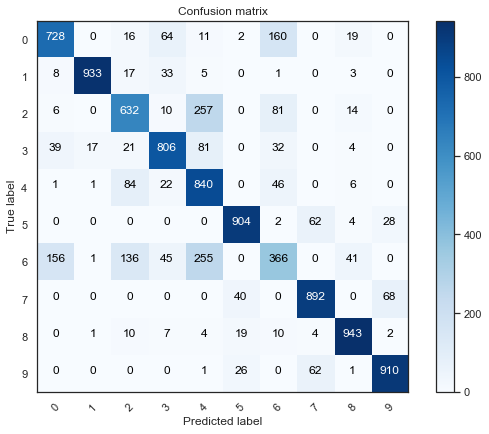

In [257]:
start = time.time()
sns.set_style("white")
cmt = np.zeros((10,10),dtype=int)
for (image, label) in test_loader:
    image = image.view(-1, seq_dim, input_dim)
    
    output = model(image).argmax(axis=1)
    for i in range(100):
        cmt[label[i].item(),output[i].item()] += 1
time.time() - start

plot_confusion_matrix(cmt, range(10))
plt.savefig('lstm2_confusion_matrix.png')

#### RNN-1

In [216]:
input_dim = 28
hidden_dim = 100
layer_dim = 1
output_dim = 10

model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [217]:
iter = 0
acc_prog = []
loss_prog = []
start_time = time.time()
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        #model.train()
        
        # Load images as tensors with gradient accumulation abilities
        images = images.view(-1, seq_dim, input_dim).requires_grad_()
        
        # Clear gradients wrt parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        # outputs.size() --> 100, 10
        outputs = model(images)
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        # Getting gradients wrt parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        
        iter += 1
        
    model.eval()

    # Calculate Accuracy
    correct = 0
    total = 0

    # Iterate through test dataset
    for images, labels in test_loader:

        # Load images to a Torch tensors with gradient accumulation abilities
        images = images.view(-1, seq_dim, input_dim)

        # Forward pass only to get logits/output
        outputs = model(images)

        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)

        # Total number of labels
        total += labels.size(0)

        # Total correct predictions
        correct += float((predicted == labels).sum())

    accuracy = 100 * correct / total

    # Print Loss
    acc_prog.append(accuracy)
    print('Epoch: {}. Iteration: {}. Loss: {:.2f}. Accuracy: {:.2f}'.format(epoch+1, iter, loss.item(), accuracy))
    loss_prog.append(loss.item())
print('Total time: {:.2f}'.format(time.time()-start_time))

Epoch: 1. Iteration: 600. Loss: 1.73. Accuracy: 26.54
Epoch: 2. Iteration: 1200. Loss: 1.37. Accuracy: 46.11
Epoch: 3. Iteration: 1800. Loss: 1.20. Accuracy: 59.55
Epoch: 4. Iteration: 2400. Loss: 0.85. Accuracy: 67.90
Epoch: 5. Iteration: 3000. Loss: 0.90. Accuracy: 57.59
Epoch: 6. Iteration: 3600. Loss: 0.57. Accuracy: 74.43
Epoch: 7. Iteration: 4200. Loss: 0.58. Accuracy: 75.63
Epoch: 8. Iteration: 4800. Loss: 0.56. Accuracy: 78.09
Epoch: 9. Iteration: 5400. Loss: 0.53. Accuracy: 77.10
Epoch: 10. Iteration: 6000. Loss: 0.54. Accuracy: 79.80
Epoch: 11. Iteration: 6600. Loss: 0.85. Accuracy: 68.99
Epoch: 12. Iteration: 7200. Loss: 0.55. Accuracy: 80.80
Epoch: 13. Iteration: 7800. Loss: 0.55. Accuracy: 76.96
Epoch: 14. Iteration: 8400. Loss: 0.56. Accuracy: 79.78
Epoch: 15. Iteration: 9000. Loss: 0.50. Accuracy: 81.20
Epoch: 16. Iteration: 9600. Loss: 0.44. Accuracy: 82.32
Epoch: 17. Iteration: 10200. Loss: 0.34. Accuracy: 81.70
Epoch: 18. Iteration: 10800. Loss: 0.34. Accuracy: 81.86


In [218]:
rnn1_loss = loss_prog
rnn1_acc = acc_prog

Confusion matrix, without normalization
[[849   5  37  36   3   1  60   0   9   0]
 [  5 963   7  19   4   0   2   0   0   0]
 [ 18   4 731   7 163   0  67   0   9   1]
 [ 58   7  16 817  47   1  48   0   6   0]
 [  1   1 108  35 761   1  90   0   2   1]
 [  0   0   0   0   0 887   0  70   6  37]
 [233   1 170  22 106   0 451   0  17   0]
 [  0   0   0   0   0   6   0 845   0 149]
 [  4   1  25   6   2  10   8   8 935   1]
 [  0   0   1   1   0   8   0  18   1 971]]


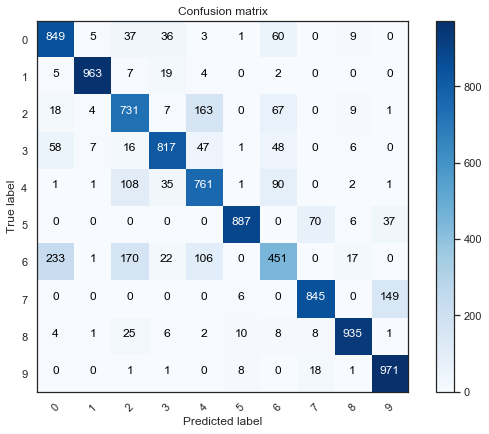

In [219]:
start = time.time()
sns.set_style("white")
cmt = np.zeros((10,10),dtype=int)
for (image, label) in test_loader:
    image = image.view(-1, seq_dim, input_dim)
    
    output = model(image).argmax(axis=1)
    for i in range(100):
        cmt[label[i].item(),output[i].item()] += 1
time.time() - start

plot_confusion_matrix(cmt, range(10))
plt.savefig('rnn1_confusion_matrix.png')

#### LSTM-1

In [220]:
input_dim = 28
hidden_dim = 100
layer_dim = 1
output_dim = 10

#device = torch.device('cpu')
model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)
criterion = nn.CrossEntropyLoss()
loss = torch.nn.CrossEntropyLoss(reduction='elementwise_mean')
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [221]:
iter = 0
acc_prog = []
loss_prog = []
start_time = time.time()
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        #model.train()
        
        # Load images as tensors with gradient accumulation abilities
        images = images.view(-1, seq_dim, input_dim).requires_grad_()
        
        # Clear gradients wrt parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        # outputs.size() --> 100, 10
        outputs = model(images)
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        # Getting gradients wrt parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        
        iter += 1
        
    model.eval()

    # Calculate Accuracy
    correct = 0
    total = 0

    # Iterate through test dataset
    for images, labels in test_loader:

        # Load images to a Torch tensors with gradient accumulation abilities
        images = images.view(-1, seq_dim, input_dim)

        # Forward pass only to get logits/output
        outputs = model(images)

        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)

        # Total number of labels
        total += labels.size(0)

        # Total correct predictions
        correct += float((predicted == labels).sum())

    accuracy = 100 * correct / total

    # Print Loss
    acc_prog.append(accuracy)
    print('Epoch: {}. Iteration: {}. Loss: {:.2f}. Accuracy: {:.2f}'.format(epoch+1, iter, loss.item(), accuracy))
    loss_prog.append(loss.item())
print('Total time: {:.2f}'.format(time.time()-start_time))

Epoch: 1. Iteration: 600. Loss: 0.79. Accuracy: 66.26
Epoch: 2. Iteration: 1200. Loss: 0.70. Accuracy: 75.68
Epoch: 3. Iteration: 1800. Loss: 0.45. Accuracy: 79.42
Epoch: 4. Iteration: 2400. Loss: 0.45. Accuracy: 83.28
Epoch: 5. Iteration: 3000. Loss: 0.47. Accuracy: 84.38
Epoch: 6. Iteration: 3600. Loss: 0.41. Accuracy: 84.39
Epoch: 7. Iteration: 4200. Loss: 0.31. Accuracy: 84.21
Epoch: 8. Iteration: 4800. Loss: 0.33. Accuracy: 85.59
Epoch: 9. Iteration: 5400. Loss: 0.19. Accuracy: 86.11
Epoch: 10. Iteration: 6000. Loss: 0.42. Accuracy: 86.47
Epoch: 11. Iteration: 6600. Loss: 0.34. Accuracy: 85.77
Epoch: 12. Iteration: 7200. Loss: 0.42. Accuracy: 86.23
Epoch: 13. Iteration: 7800. Loss: 0.29. Accuracy: 86.73
Epoch: 14. Iteration: 8400. Loss: 0.16. Accuracy: 86.83
Epoch: 15. Iteration: 9000. Loss: 0.29. Accuracy: 87.08
Epoch: 16. Iteration: 9600. Loss: 0.30. Accuracy: 87.44
Epoch: 17. Iteration: 10200. Loss: 0.39. Accuracy: 87.87
Epoch: 18. Iteration: 10800. Loss: 0.25. Accuracy: 87.60


In [222]:
lstm1_loss = loss_prog
lstm1_acc = acc_prog

Confusion matrix, without normalization
[[815   0  19  41   3   1 113   1   7   0]
 [  6 963   0  22   3   0   4   0   2   0]
 [ 15   0 828  14  81   0  55   0   7   0]
 [ 16   8  15 899  34   1  22   0   5   0]
 [  1   1 110  30 803   1  52   0   2   0]
 [  0   1   0   0   0 917   0  59   2  21]
 [124   2  92  42  80   1 647   0  12   0]
 [  0   0   0   0   0   3   0 978   0  19]
 [  3   0   4   4   5   2   2   7 971   2]
 [  0   0   0   0   0   4   1  38   0 957]]


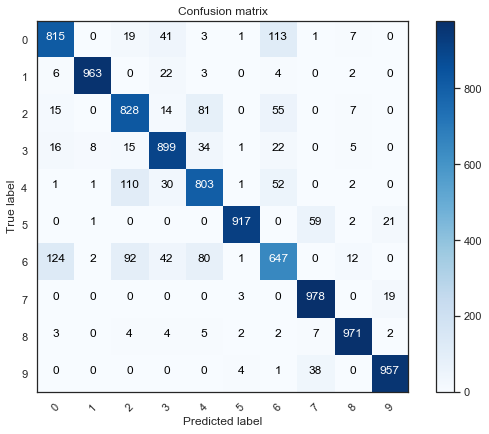

In [223]:
start = time.time()
sns.set_style("white")
cmt = np.zeros((10,10),dtype=int)
for (image, label) in test_loader:
    image = image.view(-1, seq_dim, input_dim)
    
    output = model(image).argmax(axis=1)
    for i in range(100):
        cmt[label[i].item(),output[i].item()] += 1
time.time() - start

plot_confusion_matrix(cmt, range(10))
plt.savefig('lstm1_confusion_matrix.png')

In [201]:
len(lstm1_loss)

20

In [202]:
lstm1_acc

[56.45,
 74.79,
 78.17,
 78.18,
 82.13,
 83.3,
 84.19,
 84.14,
 85.16,
 85.78,
 85.82,
 85.41,
 86.11,
 84.85,
 85.89,
 86.96,
 86.68,
 86.5,
 87.28,
 87.43,
 87.68,
 87.89,
 87.8,
 87.53]

In [200]:
len(lstm1_acc)

24

### Print the progression of the loss functions

In [133]:
len(loss_prog)

20

In [139]:
loss_prog = np.array(loss_prog)

In [179]:
loss_prog_rnn2 = loss_prog

In [236]:
loss_progression = pd.DataFrame(index=list(range(1,21)))

In [166]:
loss_progression

""
1
2
3
4
5
6
7
8
9
10


In [237]:
for idx in range(20):
    #loss_progression.loc['epoch',idx+1] = idx+1
    #loss_progression.loc[idx+1,'epoch'] = idx+1
    loss_progression.loc[idx+1,'rnn1_loss'] = rnn1_loss[idx]
    loss_progression.loc[idx+1,'lstm1_loss'] = lstm1_loss[idx]
    loss_progression.loc[idx+1,'rnn2_loss'] = rnn2_loss[idx]
    loss_progression.loc[idx+1,'latm2_loss'] = lstm2_loss[idx]

In [231]:
loss_progression

,loss,rnn1_loss,lstm1_loss,rnn2_loss,latm2_loss,epoch
1,1.967526,1.732387,0.793274,2.056529,2.290127,1.0
2,1.094035,1.365631,0.702800,1.260987,2.271007,2.0
3,0.863364,1.197622,0.453207,0.788978,2.207942,3.0
4,1.040628,0.850907,0.452646,0.805871,1.949831,4.0
5,0.698232,0.897887,0.471262,0.547945,1.536089,5.0
6,0.680236,0.569043,0.411741,0.797101,1.418236,6.0
7,0.829712,0.578166,0.308775,0.653931,1.176257,7.0
8,0.617760,0.558984,0.325326,0.532157,1.052017,8.0
9,0.557893,0.529462,0.193655,0.724055,0.921535,9.0
10,0.501368,0.536049,0.419489,0.516485,0.911709,10.0


In [158]:
loss_progression.T

,epoch,loss
1,1,1.96753
2,2,1.09404
3,3,0.863364
4,4,1.04063
5,5,0.698232
6,6,0.680236
7,7,0.829712
8,8,0.61776
9,9,0.557893
10,10,0.501368


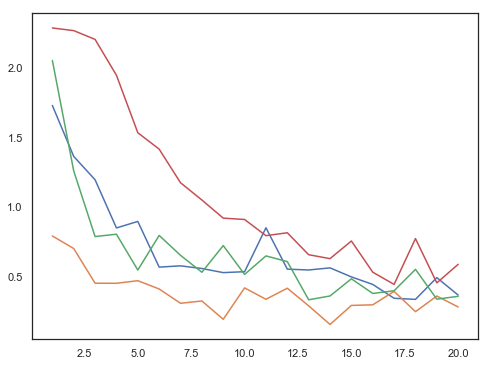

In [225]:
plt.figure()
plt.plot(range(1,21),rnn1_loss)
plt.plot(range(1,21),lstm1_loss)
plt.plot(range(1,21),rnn2_loss)
plt.plot(range(1,21),lstm2_loss)

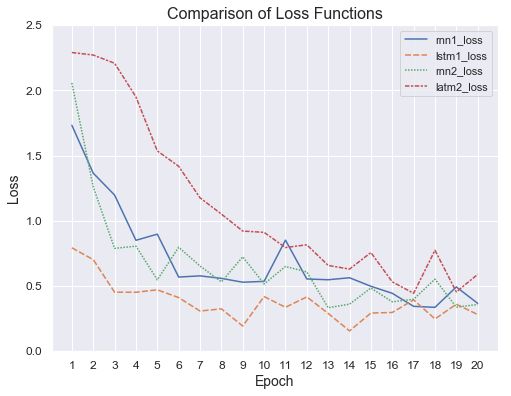

In [249]:
plt.figure()
sns.set()
#sns.set_style('whitegrid')
sns.lineplot(data=loss_progression)
plt.xticks(range(1,21),size=12)
plt.yticks(size=12)
plt.ylim((0,2.5))
plt.title('Comparison of Loss Functions',size=16)
plt.xlabel('Epoch',size=14)
plt.ylabel('Loss',size=14)
plt.savefig('compare_loss_prog.png')

#### Accuracy plot

In [250]:
acc_progression = pd.DataFrame(index=list(range(1,21)))
for idx in range(20):
    #loss_progression.loc['epoch',idx+1] = idx+1
    #loss_progression.loc[idx+1,'epoch'] = idx+1
    acc_progression.loc[idx+1,'rnn1_acc'] = rnn1_acc[idx]
    acc_progression.loc[idx+1,'lstm1_acc'] = lstm1_acc[idx]
    acc_progression.loc[idx+1,'rnn2_acc'] = rnn2_acc[idx]
    acc_progression.loc[idx+1,'latm2_acc'] = lstm2_acc[idx]

In [251]:
acc_progression

,rnn1_acc,lstm1_acc,rnn2_acc,latm2_acc
1,26.54,66.26,26.68,17.22
2,46.11,75.68,50.63,27.59
3,59.55,79.42,62.91,30.59
4,67.90,83.28,70.89,31.01
5,57.59,84.38,73.54,43.13
6,74.43,84.39,72.28,47.75
7,75.63,84.21,72.47,51.79
8,78.09,85.59,70.49,60.19
9,77.10,86.11,72.73,63.79
10,79.80,86.47,80.36,64.79


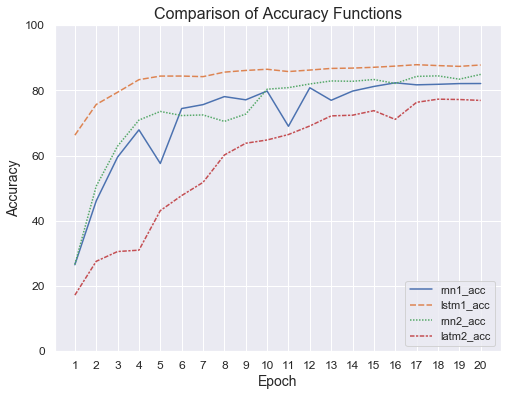

In [253]:
plt.figure()
sns.set()
#sns.set_style('whitegrid')
sns.lineplot(data=acc_progression)
plt.xticks(range(1,21),size=12)
plt.yticks(size=12)
plt.ylim((0,100))
plt.title('Comparison of Accuracy Functions',size=16)
plt.xlabel('Epoch',size=14)
plt.ylabel('Accuracy',size=14)
plt.savefig('compare_acc_prog.png')

#### Example line plot

C:\Users\iamph\Miniconda3\envs\tensorflow\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


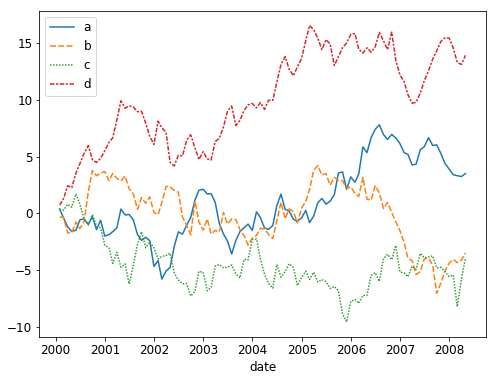

In [163]:
index = pd.date_range("1 1 2000", periods=100,
                      freq="m", name="date")
data = np.random.randn(100, 4).cumsum(axis=0)
wide_df = pd.DataFrame(data, index, ["a", "b", "c", "d"])
ax = sns.lineplot(data=wide_df)

In [164]:
wide_df

,a,b,c,d
date,,,,
2000-01-31,0.391063,-0.327351,0.318918,0.724387
2000-02-29,-0.409024,-0.359547,0.266280,1.290560
2000-03-31,-1.188571,-1.734329,0.792988,2.433870
2000-04-30,-1.600699,-1.733961,0.540189,2.260497
2000-05-31,-1.493903,-0.769556,1.698721,3.536460
2000-06-30,-0.567588,-1.342950,0.783043,4.388834
2000-07-31,-0.505284,-0.692729,-0.515373,5.299967
2000-08-31,-0.964986,1.890742,-1.036492,5.971014
2000-09-30,-0.290041,3.772519,-0.120468,4.731993
